# Sentiment analysis para comentarios de peliculas 
#### Proyecto parte 3
Ruben Gonzalez 20003314

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.metrics import roc_auc_score

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import EarlyStopping

from keras.optimizers import Adam

import keras.models
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, BatchNormalization, GlobalMaxPooling1D, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-reviews-dataset/imdb_reviews_dataset.csv


In [2]:
import tensorflow as tf

## Carga y preprocesamiento de datos

In [3]:
df = pd.read_csv('../input/imdb-reviews-dataset/imdb_reviews_dataset.csv')
df.head()

,data_type,id,rating,text
0,train,pos_0,9,Bromwell High is a cartoon comedy. It ran at t...
1,train,pos_10000,8,Homelessness (or Houselessness as George Carli...
2,train,pos_10001,10,Brilliant over-acting by Lesley Ann Warren. Be...
3,train,pos_10002,7,This is easily the most underrated film inn th...
4,train,pos_10003,8,This is not the typical Mel Brooks film. It wa...


In [4]:
df.rating.value_counts()

0     50000
1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: rating, dtype: int64

Se remueven los reviews sin rating pues no nos sirven para el analisis

In [5]:
df_etiquetado = df[df['rating'] != 0].copy() 
df_etiquetado.shape

(50000, 4)

In [6]:
df_etiquetado.rating.value_counts()

1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: rating, dtype: int64

Se crea una nueva columna que identifique si el sentimiento es positivo o no usando aquellos comentarios con ranquin mayor o igual a 7 como positivos

In [7]:
df_etiquetado['sentimiento'] = df_etiquetado.rating.apply(lambda x: 1 if x >= 7 else 0)
df_etiquetado["Length"] = df_etiquetado['text'].apply(lambda x: len(x.split()))

In [8]:
df_etiquetado.head()

,data_type,id,rating,text,sentimiento,Length
0,train,pos_0,9,Bromwell High is a cartoon comedy. It ran at t...,1,140
1,train,pos_10000,8,Homelessness (or Houselessness as George Carli...,1,428
2,train,pos_10001,10,Brilliant over-acting by Lesley Ann Warren. Be...,1,147
3,train,pos_10002,7,This is easily the most underrated film inn th...,1,124
4,train,pos_10003,8,This is not the typical Mel Brooks film. It wa...,1,120


Como el dataset ya esta segmentado en train y test, se usara esa misma segmentacion

In [9]:
from sklearn.model_selection import train_test_split


## Pre-procesamiento del texto
Se utiliza word2vec para la tokenizacion de las entradas X

In [10]:
review_lines = list()
lines = df['text'].values.tolist()

stop_words = set(stopwords.words('english'))

for line in lines:
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)

In [11]:
len(review_lines)

100000

In [12]:
import gensim

In [13]:
%%time
EMBEDDING_DIM = 256

model = gensim.models.Word2Vec(sentences=review_lines, size=EMBEDDING_DIM, window=5, workers=4, min_count=5)
words = list(model.wv.vocab)
print('Tamaño del vocabulario: %d' % len(words))

Tamaño del vocabulario: 56449
CPU times: user 4min 45s, sys: 1.56 s, total: 4min 46s
Wall time: 2min 50s


Almacenamos el vocabulario en el formato requerido para su potencial uso posterior

In [14]:
filename = 'vocabulario.txt'
model.wv.save_word2vec_format(filename, binary=False)

Recuperacion del vocabulario creado usando word2vec

In [15]:
embedding_index = {}
with open(os.path.join('./vocabulario.txt')) as fin:
    for line in fin:
        values = line.split()
        if len(values) == 2:
            print('Num words - ', values[0])
            print('EMBEDDING_DIM =', values[1])
            continue
        word = values[0]
        coefs = np.asarray(values[1:])
        embedding_index[word] = coefs

Num words -  56449
EMBEDDING_DIM = 256


In [18]:
len_text_info = df_etiquetado['Length'].describe()
len_text_info

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: Length, dtype: float64

In [19]:
# set max len for padding
max_length = int(len_text_info['mean'] + 2 * len_text_info['std'])
print(max_length) # = 200

573


In [21]:
tokenizer_obj = Tokenizer()
total_reviews = df_etiquetado['text'].values
tokenizer_obj.fit_on_texts(total_reviews)
sequences = tokenizer_obj.texts_to_sequences(total_reviews)

word_index = tokenizer_obj.word_index
print('Encontrados %s tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment = df_etiquetado['sentimiento'].values
print(review_pad.shape)
print(sentiment.shape)

Encontrados 124252 tokens.
(50000, 573)
(50000,)


In [22]:
## Diccionario que contiene las palabras unicas con el token asociado
word_index['the']

# Contiene los registros de texto tokenizados
review_pad

#Contiene el arreglo que indica si el sentimiento es positivo (1) o negativo (0)
sentiment

array([1, 1, 1, ..., 0, 0, 0])

In [23]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

words_n = 0
finde_n = 0
for word, i in word_index.items():
    words_n += 1
    if i > num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        finde_n += 1
        embedding_matrix[i] = embedding_vector

## Obteniendo particiones para entrenamiento/validacion/pruebas

In [24]:
review_pad.shape

(50000, 573)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(review_pad, sentiment, test_size = 0.02, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05, random_state = 0)

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(46550, 573)
(46550,)
(1000, 573)
(1000,)
(2450, 573)
(2450,)


## Creacion del modelo RNN usando GRU



In [27]:
modelo = Sequential()
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_length,
    trainable=False,
)

modelo.add(embedding_layer)
modelo.add(BatchNormalization())
modelo.add(Dropout(0.2))
modelo.add(GRU(units=32))
modelo.add(BatchNormalization())
modelo.add(Dropout(0.2))
modelo.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.0005)
modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 573, 256)          31808768  
_________________________________________________________________
batch_normalization (BatchNo (None, 573, 256)          1024      
_________________________________________________________________
dropout (Dropout)            (None, 573, 256)          0         
_________________________________________________________________
gru (GRU)                    (None, 32)                27840     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

## Entrenamiento

In [29]:
print('Inicio entrenamiento...')

my_callbacks = [
    EarlyStopping(patience=10),
]
bitacora = modelo.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), verbose=2, callbacks=my_callbacks)

Inicio entrenamiento...
Epoch 1/30
364/364 - 19s - loss: 0.7382 - accuracy: 0.5058 - val_loss: 0.6991 - val_accuracy: 0.4955
Epoch 2/30
364/364 - 18s - loss: 0.7038 - accuracy: 0.5099 - val_loss: 0.6999 - val_accuracy: 0.5098
Epoch 3/30
364/364 - 18s - loss: 0.6949 - accuracy: 0.5080 - val_loss: 0.6976 - val_accuracy: 0.4947
Epoch 4/30
364/364 - 18s - loss: 0.6900 - accuracy: 0.5121 - val_loss: 0.6939 - val_accuracy: 0.5155
Epoch 5/30
364/364 - 18s - loss: 0.6870 - accuracy: 0.5097 - val_loss: 0.7157 - val_accuracy: 0.4980
Epoch 6/30
364/364 - 18s - loss: 0.6853 - accuracy: 0.5167 - val_loss: 0.6913 - val_accuracy: 0.5037
Epoch 7/30
364/364 - 18s - loss: 0.6836 - accuracy: 0.5156 - val_loss: 0.6935 - val_accuracy: 0.5200
Epoch 8/30
364/364 - 18s - loss: 0.6829 - accuracy: 0.5183 - val_loss: 1.0719 - val_accuracy: 0.5208
Epoch 9/30
364/364 - 18s - loss: 0.6474 - accuracy: 0.5814 - val_loss: 0.5079 - val_accuracy: 0.7747
Epoch 10/30
364/364 - 18s - loss: 0.4050 - accuracy: 0.8206 - val_l

## Graficando el error y la precision

In [30]:
import matplotlib.pyplot as plt

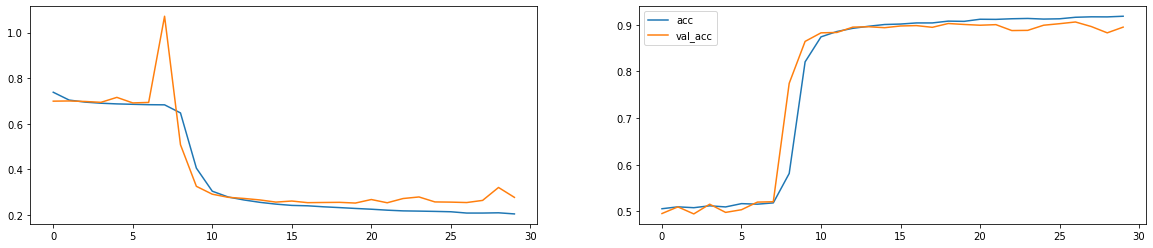

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(bitacora.history['loss'], label='loss')
axs[0].plot(bitacora.history['val_loss'], label='val_loss')

axs[1].plot(bitacora.history['accuracy'], label='acc')
axs[1].plot(bitacora.history['val_accuracy'], label='val_acc')

plt.legend();
plt.show();

## Guardando el modelo / Recuperando el modelo
Dado que ya supero el porcentaje minimo de exactitud solicitada, se procedera a almacenar el modelo

In [32]:
modelo.save('RNN-GRUModelo.h5')

In [33]:
#Cargamos nuevamente el modelo realizado. Activar solo si es necesario
#from keras.models import load_model
#modelo = load_model('CNN-Modelo.h5')

## Probando con datos de test y validando error/precision

In [34]:
metricasTest=modelo.evaluate(X_test,y_test)

32/32 [==============================] - 0s 13ms/step - loss: 0.2367 - accuracy: 0.9090


Tiene un error de 0.24 y una precision de 91%

## Se procedera a realizar otro modelo esta vez usando BERT Model para ver si se obtienen mejores resultados

Instalando librerias necesarias

In [35]:
!pip3 install ktrain

     |████████████████████████████████| 25.3 MB 35 kB/s  eta 0:00:01    |███▋                            | 2.8 MB 196 kB/s eta 0:01:55
     |████████████████████████████████| 981 kB 30.7 MB/s eta 0:00:01
     |████████████████████████████████| 242 kB 15.1 MB/s eta 0:00:01
     |████████████████████████████████| 884 kB 16.8 MB/s eta 0:00:01
     |████████████████████████████████| 468 kB 17.4 MB/s eta 0:00:01
     |████████████████████████████████| 496 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 15.7 MB/s eta 0:00:01


  Created wheel for ktrain: filename=ktrain-0.21.3-py3-none-any.whl size=25270202 sha256=3e852279ead1a5d7d401324056ec92de0f90c5b5cc8faec610cd524d4b5898ef
  Stored in directory: /root/.cache/pip/wheels/0c/98/fc/0738e516f4bdfea4812b28cd7a512104d8c1748a9da4373405
  Created wheel for keras-bert: filename=keras_bert-0.86.0-py3-none-any.whl size=34147 sha256=2177bf2c96ba5a7fbf1963cdb994e9370d0f5fce1348c9763ae37fc1ff9e4f27
  Stored in directory: /root/.cache/pip/wheels/fc/c1/0a/eb9187261b3f192ac314aefb54fe66f50540c3edb906599633
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=27be95a14a649020d5d3cb8a6c026bbd77e54283ceb35ddf3d831a459f2251aa
  Stored in directory: /root/.cache/pip/wheels/59/f6/9d/85068904dba861c0b9af74e286265a08da438748ee5ae56067
  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7423 sha256=ec96a848b9afe6cb89fda54ee6434490dac29d56a79db3c9918ce53b2d9168a1
  Stored in directory: /root/.cache/pip/wheels/dc/cc/62

In [36]:
import os.path
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Creando datasets de training y de test

In [37]:
df_etiquetado.head()

,data_type,id,rating,text,sentimiento,Length
0,train,pos_0,9,Bromwell High is a cartoon comedy. It ran at t...,1,140
1,train,pos_10000,8,Homelessness (or Houselessness as George Carli...,1,428
2,train,pos_10001,10,Brilliant over-acting by Lesley Ann Warren. Be...,1,147
3,train,pos_10002,7,This is easily the most underrated film inn th...,1,124
4,train,pos_10003,8,This is not the typical Mel Brooks film. It wa...,1,120


In [38]:
(X_train_bert,  y_train_bert), (X_val_bert, y_val_bert), preproc = text.texts_from_df(df_etiquetado,
                                                                                     'text',
                                                                                     label_columns = ['sentimiento'],
                                                                                     preprocess_mode = 'bert',
                                                                                     maxlen = 500)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## Construyendo el modelo BERT

In [39]:
modeloBert = text.text_classifier(name='bert',
                             train_data=(X_train_bert, y_train_bert),
                             preproc=preproc)

Is Multi-Label? False
maxlen is 500
done.


## Entrenando el modelo BERT

In [44]:
learner = ktrain.get_learner(model=modeloBert,
                             train_data=(X_train_bert, y_train_bert),
                             val_data=(X_val_bert, y_val_bert),
                             batch_size=6)

In [45]:
learner.fit_onecycle(lr=2e-5,
                     epochs=1)



begin training using onecycle policy with max lr of 2e-05...


 169/7500 [..............................] - ETA: 0s - loss: 0.6746 - accuracy: 0.66 - ETA: 55:19 - loss: 0.6366 - accuracy: 0.833 - ETA: 1:18:25 - loss: 0.6120 - accuracy: 0.777 - ETA: 1:23:33 - loss: 0.6634 - accuracy: 0.750 - ETA: 1:26:25 - loss: 0.6742 - accuracy: 0.733 - ETA: 1:28:18 - loss: 0.6583 - accuracy: 0.722 - ETA: 1:29:52 - loss: 0.6768 - accuracy: 0.666 - ETA: 1:30:57 - loss: 0.6838 - accuracy: 0.625 - ETA: 1:31:47 - loss: 0.6892 - accuracy: 0.611 - ETA: 1:32:54 - loss: 0.6894 - accuracy: 0.600 - ETA: 1:34:24 - loss: 0.6906 - accuracy: 0.575 - ETA: 1:34:30 - loss: 0.6874 - accuracy: 0.569 - ETA: 1:34:32 - loss: 0.6821 - accuracy: 0.576 - ETA: 1:34:44 - loss: 0.6756 - accuracy: 0.583 - ETA: 1:35:14 - loss: 0.6804 - accuracy: 0.566 - ETA: 1:36:01 - loss: 0.6748 - accuracy: 0.572 - ETA: 1:36:08 - loss: 0.6782 - accuracy: 0.558 - ETA: 1:37:09 - loss: 0.6786 - accuracy: 0.564 - ETA: 1:38:02 - loss: 0.6709 - accuracy: 0.587 - ETA: 1:37:54 - loss: 0.6697 - accuracy: 0.591 - ETA

 339/7500 [>.............................] - ETA: 1:36:59 - loss: 0.6176 - accuracy: 0.671 - ETA: 1:36:58 - loss: 0.6172 - accuracy: 0.672 - ETA: 1:36:56 - loss: 0.6170 - accuracy: 0.672 - ETA: 1:36:54 - loss: 0.6152 - accuracy: 0.674 - ETA: 1:36:53 - loss: 0.6150 - accuracy: 0.674 - ETA: 1:36:53 - loss: 0.6147 - accuracy: 0.674 - ETA: 1:36:56 - loss: 0.6149 - accuracy: 0.673 - ETA: 1:36:55 - loss: 0.6139 - accuracy: 0.675 - ETA: 1:36:53 - loss: 0.6142 - accuracy: 0.675 - ETA: 1:36:53 - loss: 0.6131 - accuracy: 0.676 - ETA: 1:36:52 - loss: 0.6132 - accuracy: 0.675 - ETA: 1:36:55 - loss: 0.6122 - accuracy: 0.677 - ETA: 1:36:57 - loss: 0.6132 - accuracy: 0.675 - ETA: 1:36:59 - loss: 0.6119 - accuracy: 0.676 - ETA: 1:36:57 - loss: 0.6106 - accuracy: 0.678 - ETA: 1:36:56 - loss: 0.6100 - accuracy: 0.680 - ETA: 1:36:55 - loss: 0.6090 - accuracy: 0.681 - ETA: 1:36:53 - loss: 0.6079 - accuracy: 0.681 - ETA: 1:36:52 - loss: 0.6070 - accuracy: 0.683 - ETA: 1:36:51 - loss: 0.6064 - accuracy: 0.6

 509/7500 [=>............................] - ETA: 1:34:56 - loss: 0.5150 - accuracy: 0.748 - ETA: 1:34:55 - loss: 0.5146 - accuracy: 0.748 - ETA: 1:34:54 - loss: 0.5135 - accuracy: 0.749 - ETA: 1:34:53 - loss: 0.5127 - accuracy: 0.749 - ETA: 1:34:52 - loss: 0.5119 - accuracy: 0.750 - ETA: 1:34:51 - loss: 0.5119 - accuracy: 0.749 - ETA: 1:34:50 - loss: 0.5127 - accuracy: 0.749 - ETA: 1:34:50 - loss: 0.5151 - accuracy: 0.748 - ETA: 1:34:50 - loss: 0.5163 - accuracy: 0.748 - ETA: 1:34:49 - loss: 0.5181 - accuracy: 0.747 - ETA: 1:34:48 - loss: 0.5183 - accuracy: 0.748 - ETA: 1:34:46 - loss: 0.5179 - accuracy: 0.747 - ETA: 1:34:45 - loss: 0.5180 - accuracy: 0.748 - ETA: 1:34:44 - loss: 0.5172 - accuracy: 0.748 - ETA: 1:34:43 - loss: 0.5166 - accuracy: 0.749 - ETA: 1:34:42 - loss: 0.5172 - accuracy: 0.748 - ETA: 1:34:41 - loss: 0.5165 - accuracy: 0.749 - ETA: 1:34:40 - loss: 0.5159 - accuracy: 0.750 - ETA: 1:34:39 - loss: 0.5155 - accuracy: 0.750 - ETA: 1:34:38 - loss: 0.5149 - accuracy: 0.7

 679/7500 [=>............................] - ETA: 1:32:45 - loss: 0.4476 - accuracy: 0.790 - ETA: 1:32:44 - loss: 0.4469 - accuracy: 0.790 - ETA: 1:32:43 - loss: 0.4467 - accuracy: 0.791 - ETA: 1:32:43 - loss: 0.4469 - accuracy: 0.790 - ETA: 1:32:42 - loss: 0.4462 - accuracy: 0.790 - ETA: 1:32:41 - loss: 0.4460 - accuracy: 0.790 - ETA: 1:32:40 - loss: 0.4456 - accuracy: 0.791 - ETA: 1:32:39 - loss: 0.4456 - accuracy: 0.790 - ETA: 1:32:38 - loss: 0.4452 - accuracy: 0.791 - ETA: 1:32:37 - loss: 0.4447 - accuracy: 0.791 - ETA: 1:32:36 - loss: 0.4446 - accuracy: 0.791 - ETA: 1:32:35 - loss: 0.4447 - accuracy: 0.791 - ETA: 1:32:34 - loss: 0.4440 - accuracy: 0.791 - ETA: 1:32:33 - loss: 0.4439 - accuracy: 0.791 - ETA: 1:32:33 - loss: 0.4433 - accuracy: 0.792 - ETA: 1:32:32 - loss: 0.4427 - accuracy: 0.792 - ETA: 1:32:31 - loss: 0.4420 - accuracy: 0.792 - ETA: 1:32:31 - loss: 0.4417 - accuracy: 0.792 - ETA: 1:32:30 - loss: 0.4411 - accuracy: 0.793 - ETA: 1:32:29 - loss: 0.4406 - accuracy: 0.7

 849/7500 [==>...........................] - ETA: 1:30:26 - loss: 0.3964 - accuracy: 0.816 - ETA: 1:30:25 - loss: 0.3963 - accuracy: 0.816 - ETA: 1:30:24 - loss: 0.3960 - accuracy: 0.817 - ETA: 1:30:24 - loss: 0.3962 - accuracy: 0.817 - ETA: 1:30:23 - loss: 0.3964 - accuracy: 0.817 - ETA: 1:30:22 - loss: 0.3959 - accuracy: 0.817 - ETA: 1:30:21 - loss: 0.3955 - accuracy: 0.817 - ETA: 1:30:20 - loss: 0.3953 - accuracy: 0.817 - ETA: 1:30:19 - loss: 0.3949 - accuracy: 0.818 - ETA: 1:30:18 - loss: 0.3948 - accuracy: 0.818 - ETA: 1:30:17 - loss: 0.3943 - accuracy: 0.818 - ETA: 1:30:16 - loss: 0.3946 - accuracy: 0.817 - ETA: 1:30:15 - loss: 0.3950 - accuracy: 0.817 - ETA: 1:30:15 - loss: 0.3945 - accuracy: 0.817 - ETA: 1:30:14 - loss: 0.3941 - accuracy: 0.818 - ETA: 1:30:13 - loss: 0.3943 - accuracy: 0.818 - ETA: 1:30:13 - loss: 0.3938 - accuracy: 0.818 - ETA: 1:30:13 - loss: 0.3933 - accuracy: 0.818 - ETA: 1:30:12 - loss: 0.3928 - accuracy: 0.818 - ETA: 1:30:11 - loss: 0.3929 - accuracy: 0.8

1019/7500 [===>..........................] - ETA: 1:28:12 - loss: 0.3667 - accuracy: 0.831 - ETA: 1:28:11 - loss: 0.3668 - accuracy: 0.831 - ETA: 1:28:10 - loss: 0.3664 - accuracy: 0.831 - ETA: 1:28:09 - loss: 0.3664 - accuracy: 0.831 - ETA: 1:28:08 - loss: 0.3666 - accuracy: 0.831 - ETA: 1:28:07 - loss: 0.3663 - accuracy: 0.831 - ETA: 1:28:07 - loss: 0.3663 - accuracy: 0.831 - ETA: 1:28:06 - loss: 0.3668 - accuracy: 0.831 - ETA: 1:28:06 - loss: 0.3665 - accuracy: 0.831 - ETA: 1:28:05 - loss: 0.3662 - accuracy: 0.831 - ETA: 1:28:05 - loss: 0.3662 - accuracy: 0.831 - ETA: 1:28:04 - loss: 0.3660 - accuracy: 0.831 - ETA: 1:28:03 - loss: 0.3656 - accuracy: 0.831 - ETA: 1:28:02 - loss: 0.3654 - accuracy: 0.831 - ETA: 1:28:01 - loss: 0.3651 - accuracy: 0.832 - ETA: 1:28:00 - loss: 0.3647 - accuracy: 0.832 - ETA: 1:27:59 - loss: 0.3646 - accuracy: 0.832 - ETA: 1:27:58 - loss: 0.3644 - accuracy: 0.832 - ETA: 1:27:57 - loss: 0.3648 - accuracy: 0.832 - ETA: 1:27:56 - loss: 0.3644 - accuracy: 0.8

1189/7500 [===>..........................] - ETA: 1:25:56 - loss: 0.3510 - accuracy: 0.841 - ETA: 1:25:55 - loss: 0.3507 - accuracy: 0.841 - ETA: 1:25:54 - loss: 0.3506 - accuracy: 0.841 - ETA: 1:25:53 - loss: 0.3503 - accuracy: 0.841 - ETA: 1:25:52 - loss: 0.3503 - accuracy: 0.841 - ETA: 1:25:52 - loss: 0.3503 - accuracy: 0.841 - ETA: 1:25:51 - loss: 0.3509 - accuracy: 0.841 - ETA: 1:25:50 - loss: 0.3506 - accuracy: 0.841 - ETA: 1:25:49 - loss: 0.3503 - accuracy: 0.841 - ETA: 1:25:49 - loss: 0.3502 - accuracy: 0.841 - ETA: 1:25:48 - loss: 0.3502 - accuracy: 0.841 - ETA: 1:25:47 - loss: 0.3501 - accuracy: 0.841 - ETA: 1:25:46 - loss: 0.3498 - accuracy: 0.841 - ETA: 1:25:45 - loss: 0.3497 - accuracy: 0.842 - ETA: 1:25:44 - loss: 0.3494 - accuracy: 0.842 - ETA: 1:25:43 - loss: 0.3491 - accuracy: 0.842 - ETA: 1:25:42 - loss: 0.3489 - accuracy: 0.842 - ETA: 1:25:41 - loss: 0.3492 - accuracy: 0.842 - ETA: 1:25:41 - loss: 0.3490 - accuracy: 0.842 - ETA: 1:25:41 - loss: 0.3488 - accuracy: 0.8

1359/7500 [====>.........................] - ETA: 1:23:39 - loss: 0.3363 - accuracy: 0.849 - ETA: 1:23:38 - loss: 0.3361 - accuracy: 0.849 - ETA: 1:23:37 - loss: 0.3360 - accuracy: 0.850 - ETA: 1:23:36 - loss: 0.3358 - accuracy: 0.850 - ETA: 1:23:36 - loss: 0.3356 - accuracy: 0.850 - ETA: 1:23:35 - loss: 0.3354 - accuracy: 0.850 - ETA: 1:23:34 - loss: 0.3352 - accuracy: 0.850 - ETA: 1:23:33 - loss: 0.3353 - accuracy: 0.850 - ETA: 1:23:32 - loss: 0.3350 - accuracy: 0.850 - ETA: 1:23:31 - loss: 0.3349 - accuracy: 0.850 - ETA: 1:23:30 - loss: 0.3348 - accuracy: 0.850 - ETA: 1:23:29 - loss: 0.3346 - accuracy: 0.850 - ETA: 1:23:28 - loss: 0.3345 - accuracy: 0.850 - ETA: 1:23:28 - loss: 0.3346 - accuracy: 0.850 - ETA: 1:23:27 - loss: 0.3346 - accuracy: 0.850 - ETA: 1:23:26 - loss: 0.3344 - accuracy: 0.850 - ETA: 1:23:26 - loss: 0.3343 - accuracy: 0.850 - ETA: 1:23:25 - loss: 0.3341 - accuracy: 0.851 - ETA: 1:23:24 - loss: 0.3341 - accuracy: 0.851 - ETA: 1:23:23 - loss: 0.3340 - accuracy: 0.8

1529/7500 [=====>........................] - ETA: 1:21:23 - loss: 0.3238 - accuracy: 0.856 - ETA: 1:21:22 - loss: 0.3238 - accuracy: 0.856 - ETA: 1:21:21 - loss: 0.3237 - accuracy: 0.856 - ETA: 1:21:20 - loss: 0.3236 - accuracy: 0.856 - ETA: 1:21:19 - loss: 0.3235 - accuracy: 0.856 - ETA: 1:21:19 - loss: 0.3232 - accuracy: 0.856 - ETA: 1:21:18 - loss: 0.3230 - accuracy: 0.856 - ETA: 1:21:17 - loss: 0.3228 - accuracy: 0.856 - ETA: 1:21:16 - loss: 0.3226 - accuracy: 0.856 - ETA: 1:21:15 - loss: 0.3224 - accuracy: 0.856 - ETA: 1:21:14 - loss: 0.3223 - accuracy: 0.856 - ETA: 1:21:14 - loss: 0.3222 - accuracy: 0.856 - ETA: 1:21:13 - loss: 0.3220 - accuracy: 0.857 - ETA: 1:21:12 - loss: 0.3219 - accuracy: 0.857 - ETA: 1:21:12 - loss: 0.3217 - accuracy: 0.857 - ETA: 1:21:11 - loss: 0.3214 - accuracy: 0.857 - ETA: 1:21:10 - loss: 0.3213 - accuracy: 0.857 - ETA: 1:21:10 - loss: 0.3213 - accuracy: 0.857 - ETA: 1:21:09 - loss: 0.3211 - accuracy: 0.857 - ETA: 1:21:08 - loss: 0.3209 - accuracy: 0.8

1699/7500 [=====>........................] - ETA: 1:19:07 - loss: 0.3158 - accuracy: 0.861 - ETA: 1:19:06 - loss: 0.3157 - accuracy: 0.861 - ETA: 1:19:05 - loss: 0.3156 - accuracy: 0.861 - ETA: 1:19:05 - loss: 0.3154 - accuracy: 0.861 - ETA: 1:19:04 - loss: 0.3154 - accuracy: 0.861 - ETA: 1:19:03 - loss: 0.3153 - accuracy: 0.861 - ETA: 1:19:02 - loss: 0.3153 - accuracy: 0.861 - ETA: 1:19:02 - loss: 0.3153 - accuracy: 0.861 - ETA: 1:19:01 - loss: 0.3152 - accuracy: 0.861 - ETA: 1:19:00 - loss: 0.3153 - accuracy: 0.861 - ETA: 1:18:59 - loss: 0.3153 - accuracy: 0.861 - ETA: 1:18:59 - loss: 0.3151 - accuracy: 0.861 - ETA: 1:18:58 - loss: 0.3151 - accuracy: 0.861 - ETA: 1:18:57 - loss: 0.3152 - accuracy: 0.861 - ETA: 1:18:56 - loss: 0.3151 - accuracy: 0.861 - ETA: 1:18:55 - loss: 0.3149 - accuracy: 0.861 - ETA: 1:18:54 - loss: 0.3149 - accuracy: 0.861 - ETA: 1:18:53 - loss: 0.3148 - accuracy: 0.861 - ETA: 1:18:53 - loss: 0.3147 - accuracy: 0.861 - ETA: 1:18:52 - loss: 0.3147 - accuracy: 0.8

1869/7500 [======>.......................] - ETA: 1:16:53 - loss: 0.3060 - accuracy: 0.866 - ETA: 1:16:52 - loss: 0.3059 - accuracy: 0.866 - ETA: 1:16:52 - loss: 0.3061 - accuracy: 0.866 - ETA: 1:16:51 - loss: 0.3061 - accuracy: 0.866 - ETA: 1:16:50 - loss: 0.3059 - accuracy: 0.866 - ETA: 1:16:49 - loss: 0.3058 - accuracy: 0.866 - ETA: 1:16:48 - loss: 0.3056 - accuracy: 0.866 - ETA: 1:16:47 - loss: 0.3055 - accuracy: 0.866 - ETA: 1:16:46 - loss: 0.3054 - accuracy: 0.866 - ETA: 1:16:46 - loss: 0.3054 - accuracy: 0.866 - ETA: 1:16:45 - loss: 0.3052 - accuracy: 0.866 - ETA: 1:16:44 - loss: 0.3054 - accuracy: 0.866 - ETA: 1:16:43 - loss: 0.3052 - accuracy: 0.866 - ETA: 1:16:42 - loss: 0.3051 - accuracy: 0.866 - ETA: 1:16:41 - loss: 0.3051 - accuracy: 0.866 - ETA: 1:16:40 - loss: 0.3050 - accuracy: 0.866 - ETA: 1:16:40 - loss: 0.3049 - accuracy: 0.866 - ETA: 1:16:39 - loss: 0.3048 - accuracy: 0.866 - ETA: 1:16:38 - loss: 0.3049 - accuracy: 0.866 - ETA: 1:16:37 - loss: 0.3047 - accuracy: 0.8

2039/7500 [=======>......................] - ETA: 1:14:38 - loss: 0.2963 - accuracy: 0.871 - ETA: 1:14:37 - loss: 0.2963 - accuracy: 0.871 - ETA: 1:14:37 - loss: 0.2963 - accuracy: 0.871 - ETA: 1:14:36 - loss: 0.2963 - accuracy: 0.871 - ETA: 1:14:35 - loss: 0.2965 - accuracy: 0.871 - ETA: 1:14:34 - loss: 0.2965 - accuracy: 0.871 - ETA: 1:14:33 - loss: 0.2963 - accuracy: 0.871 - ETA: 1:14:32 - loss: 0.2962 - accuracy: 0.871 - ETA: 1:14:32 - loss: 0.2961 - accuracy: 0.871 - ETA: 1:14:31 - loss: 0.2961 - accuracy: 0.871 - ETA: 1:14:30 - loss: 0.2960 - accuracy: 0.871 - ETA: 1:14:29 - loss: 0.2960 - accuracy: 0.871 - ETA: 1:14:29 - loss: 0.2962 - accuracy: 0.871 - ETA: 1:14:28 - loss: 0.2962 - accuracy: 0.871 - ETA: 1:14:27 - loss: 0.2961 - accuracy: 0.871 - ETA: 1:14:27 - loss: 0.2960 - accuracy: 0.871 - ETA: 1:14:26 - loss: 0.2958 - accuracy: 0.871 - ETA: 1:14:25 - loss: 0.2958 - accuracy: 0.871 - ETA: 1:14:24 - loss: 0.2959 - accuracy: 0.871 - ETA: 1:14:23 - loss: 0.2957 - accuracy: 0.8

2209/7500 [=======>......................] - ETA: 1:12:22 - loss: 0.2912 - accuracy: 0.873 - ETA: 1:12:21 - loss: 0.2911 - accuracy: 0.873 - ETA: 1:12:20 - loss: 0.2910 - accuracy: 0.873 - ETA: 1:12:19 - loss: 0.2911 - accuracy: 0.873 - ETA: 1:12:18 - loss: 0.2911 - accuracy: 0.873 - ETA: 1:12:18 - loss: 0.2910 - accuracy: 0.873 - ETA: 1:12:17 - loss: 0.2912 - accuracy: 0.873 - ETA: 1:12:16 - loss: 0.2914 - accuracy: 0.873 - ETA: 1:12:15 - loss: 0.2913 - accuracy: 0.873 - ETA: 1:12:14 - loss: 0.2913 - accuracy: 0.873 - ETA: 1:12:13 - loss: 0.2912 - accuracy: 0.873 - ETA: 1:12:13 - loss: 0.2913 - accuracy: 0.873 - ETA: 1:12:12 - loss: 0.2915 - accuracy: 0.873 - ETA: 1:12:11 - loss: 0.2914 - accuracy: 0.873 - ETA: 1:12:10 - loss: 0.2914 - accuracy: 0.873 - ETA: 1:12:10 - loss: 0.2914 - accuracy: 0.873 - ETA: 1:12:09 - loss: 0.2914 - accuracy: 0.873 - ETA: 1:12:08 - loss: 0.2913 - accuracy: 0.873 - ETA: 1:12:08 - loss: 0.2913 - accuracy: 0.873 - ETA: 1:12:07 - loss: 0.2912 - accuracy: 0.8

2379/7500 [========>.....................] - ETA: 1:10:08 - loss: 0.2862 - accuracy: 0.876 - ETA: 1:10:07 - loss: 0.2861 - accuracy: 0.876 - ETA: 1:10:06 - loss: 0.2860 - accuracy: 0.876 - ETA: 1:10:06 - loss: 0.2860 - accuracy: 0.876 - ETA: 1:10:05 - loss: 0.2859 - accuracy: 0.876 - ETA: 1:10:04 - loss: 0.2858 - accuracy: 0.876 - ETA: 1:10:03 - loss: 0.2860 - accuracy: 0.876 - ETA: 1:10:03 - loss: 0.2859 - accuracy: 0.876 - ETA: 1:10:02 - loss: 0.2858 - accuracy: 0.876 - ETA: 1:10:01 - loss: 0.2856 - accuracy: 0.876 - ETA: 1:10:00 - loss: 0.2856 - accuracy: 0.876 - ETA: 1:09:59 - loss: 0.2856 - accuracy: 0.876 - ETA: 1:09:59 - loss: 0.2855 - accuracy: 0.876 - ETA: 1:09:58 - loss: 0.2855 - accuracy: 0.876 - ETA: 1:09:57 - loss: 0.2854 - accuracy: 0.876 - ETA: 1:09:56 - loss: 0.2853 - accuracy: 0.876 - ETA: 1:09:55 - loss: 0.2852 - accuracy: 0.877 - ETA: 1:09:55 - loss: 0.2851 - accuracy: 0.877 - ETA: 1:09:54 - loss: 0.2854 - accuracy: 0.876 - ETA: 1:09:53 - loss: 0.2854 - accuracy: 0.8

2549/7500 [=========>....................] - ETA: 1:07:52 - loss: 0.2804 - accuracy: 0.879 - ETA: 1:07:51 - loss: 0.2802 - accuracy: 0.879 - ETA: 1:07:50 - loss: 0.2801 - accuracy: 0.879 - ETA: 1:07:49 - loss: 0.2802 - accuracy: 0.879 - ETA: 1:07:49 - loss: 0.2803 - accuracy: 0.879 - ETA: 1:07:48 - loss: 0.2803 - accuracy: 0.879 - ETA: 1:07:47 - loss: 0.2805 - accuracy: 0.879 - ETA: 1:07:46 - loss: 0.2804 - accuracy: 0.879 - ETA: 1:07:45 - loss: 0.2804 - accuracy: 0.879 - ETA: 1:07:44 - loss: 0.2803 - accuracy: 0.879 - ETA: 1:07:44 - loss: 0.2803 - accuracy: 0.879 - ETA: 1:07:43 - loss: 0.2803 - accuracy: 0.879 - ETA: 1:07:42 - loss: 0.2802 - accuracy: 0.879 - ETA: 1:07:41 - loss: 0.2802 - accuracy: 0.879 - ETA: 1:07:41 - loss: 0.2801 - accuracy: 0.879 - ETA: 1:07:40 - loss: 0.2804 - accuracy: 0.879 - ETA: 1:07:39 - loss: 0.2804 - accuracy: 0.879 - ETA: 1:07:38 - loss: 0.2804 - accuracy: 0.879 - ETA: 1:07:38 - loss: 0.2805 - accuracy: 0.879 - ETA: 1:07:37 - loss: 0.2804 - accuracy: 0.8

2719/7500 [=========>....................] - ETA: 1:05:36 - loss: 0.2792 - accuracy: 0.880 - ETA: 1:05:35 - loss: 0.2791 - accuracy: 0.880 - ETA: 1:05:34 - loss: 0.2791 - accuracy: 0.880 - ETA: 1:05:34 - loss: 0.2790 - accuracy: 0.880 - ETA: 1:05:33 - loss: 0.2790 - accuracy: 0.880 - ETA: 1:05:32 - loss: 0.2791 - accuracy: 0.880 - ETA: 1:05:31 - loss: 0.2791 - accuracy: 0.880 - ETA: 1:05:31 - loss: 0.2790 - accuracy: 0.880 - ETA: 1:05:30 - loss: 0.2790 - accuracy: 0.880 - ETA: 1:05:29 - loss: 0.2789 - accuracy: 0.880 - ETA: 1:05:28 - loss: 0.2790 - accuracy: 0.880 - ETA: 1:05:27 - loss: 0.2789 - accuracy: 0.880 - ETA: 1:05:27 - loss: 0.2788 - accuracy: 0.880 - ETA: 1:05:26 - loss: 0.2788 - accuracy: 0.880 - ETA: 1:05:25 - loss: 0.2787 - accuracy: 0.880 - ETA: 1:05:24 - loss: 0.2787 - accuracy: 0.880 - ETA: 1:05:23 - loss: 0.2787 - accuracy: 0.880 - ETA: 1:05:22 - loss: 0.2787 - accuracy: 0.880 - ETA: 1:05:22 - loss: 0.2788 - accuracy: 0.880 - ETA: 1:05:21 - loss: 0.2788 - accuracy: 0.8

2889/7500 [==========>...................] - ETA: 1:03:22 - loss: 0.2753 - accuracy: 0.882 - ETA: 1:03:21 - loss: 0.2753 - accuracy: 0.882 - ETA: 1:03:20 - loss: 0.2753 - accuracy: 0.882 - ETA: 1:03:19 - loss: 0.2752 - accuracy: 0.882 - ETA: 1:03:18 - loss: 0.2752 - accuracy: 0.882 - ETA: 1:03:17 - loss: 0.2751 - accuracy: 0.882 - ETA: 1:03:17 - loss: 0.2750 - accuracy: 0.882 - ETA: 1:03:16 - loss: 0.2750 - accuracy: 0.882 - ETA: 1:03:15 - loss: 0.2749 - accuracy: 0.882 - ETA: 1:03:14 - loss: 0.2749 - accuracy: 0.882 - ETA: 1:03:13 - loss: 0.2748 - accuracy: 0.882 - ETA: 1:03:13 - loss: 0.2747 - accuracy: 0.882 - ETA: 1:03:12 - loss: 0.2746 - accuracy: 0.882 - ETA: 1:03:11 - loss: 0.2747 - accuracy: 0.882 - ETA: 1:03:10 - loss: 0.2747 - accuracy: 0.882 - ETA: 1:03:10 - loss: 0.2746 - accuracy: 0.882 - ETA: 1:03:09 - loss: 0.2746 - accuracy: 0.882 - ETA: 1:03:08 - loss: 0.2745 - accuracy: 0.882 - ETA: 1:03:07 - loss: 0.2744 - accuracy: 0.882 - ETA: 1:03:06 - loss: 0.2743 - accuracy: 0.8

3063/7500 [===========>..................] - ETA: 1:01:07 - loss: 0.2712 - accuracy: 0.884 - ETA: 1:01:07 - loss: 0.2711 - accuracy: 0.884 - ETA: 1:01:06 - loss: 0.2711 - accuracy: 0.884 - ETA: 1:01:05 - loss: 0.2711 - accuracy: 0.884 - ETA: 1:01:04 - loss: 0.2710 - accuracy: 0.884 - ETA: 1:01:04 - loss: 0.2711 - accuracy: 0.884 - ETA: 1:01:03 - loss: 0.2710 - accuracy: 0.884 - ETA: 1:01:02 - loss: 0.2711 - accuracy: 0.884 - ETA: 1:01:01 - loss: 0.2710 - accuracy: 0.884 - ETA: 1:01:00 - loss: 0.2709 - accuracy: 0.884 - ETA: 1:00:59 - loss: 0.2709 - accuracy: 0.884 - ETA: 1:00:59 - loss: 0.2708 - accuracy: 0.884 - ETA: 1:00:58 - loss: 0.2709 - accuracy: 0.884 - ETA: 1:00:57 - loss: 0.2710 - accuracy: 0.884 - ETA: 1:00:56 - loss: 0.2709 - accuracy: 0.884 - ETA: 1:00:55 - loss: 0.2708 - accuracy: 0.884 - ETA: 1:00:55 - loss: 0.2708 - accuracy: 0.884 - ETA: 1:00:54 - loss: 0.2708 - accuracy: 0.884 - ETA: 1:00:53 - loss: 0.2709 - accuracy: 0.884 - ETA: 1:00:52 - loss: 0.2709 - accuracy: 0.8

3241/7500 [===========>..................] - ETA: 58:49 - loss: 0.2683 - accuracy: 0.886 - ETA: 58:48 - loss: 0.2682 - accuracy: 0.886 - ETA: 58:47 - loss: 0.2682 - accuracy: 0.886 - ETA: 58:47 - loss: 0.2681 - accuracy: 0.886 - ETA: 58:46 - loss: 0.2681 - accuracy: 0.886 - ETA: 58:45 - loss: 0.2680 - accuracy: 0.886 - ETA: 58:45 - loss: 0.2680 - accuracy: 0.886 - ETA: 58:44 - loss: 0.2680 - accuracy: 0.886 - ETA: 58:43 - loss: 0.2679 - accuracy: 0.886 - ETA: 58:42 - loss: 0.2679 - accuracy: 0.886 - ETA: 58:41 - loss: 0.2678 - accuracy: 0.886 - ETA: 58:40 - loss: 0.2679 - accuracy: 0.886 - ETA: 58:40 - loss: 0.2679 - accuracy: 0.886 - ETA: 58:39 - loss: 0.2678 - accuracy: 0.886 - ETA: 58:38 - loss: 0.2677 - accuracy: 0.886 - ETA: 58:37 - loss: 0.2679 - accuracy: 0.886 - ETA: 58:36 - loss: 0.2678 - accuracy: 0.886 - ETA: 58:36 - loss: 0.2677 - accuracy: 0.886 - ETA: 58:35 - loss: 0.2677 - accuracy: 0.886 - ETA: 58:34 - loss: 0.2677 - accuracy: 0.886 - ETA: 58:33 - loss: 0.2676 - accurac

3419/7500 [============>.................] - ETA: 56:27 - loss: 0.2653 - accuracy: 0.887 - ETA: 56:27 - loss: 0.2653 - accuracy: 0.887 - ETA: 56:26 - loss: 0.2653 - accuracy: 0.887 - ETA: 56:25 - loss: 0.2653 - accuracy: 0.887 - ETA: 56:24 - loss: 0.2653 - accuracy: 0.887 - ETA: 56:23 - loss: 0.2652 - accuracy: 0.887 - ETA: 56:23 - loss: 0.2652 - accuracy: 0.887 - ETA: 56:22 - loss: 0.2651 - accuracy: 0.887 - ETA: 56:21 - loss: 0.2651 - accuracy: 0.887 - ETA: 56:20 - loss: 0.2651 - accuracy: 0.887 - ETA: 56:19 - loss: 0.2650 - accuracy: 0.887 - ETA: 56:19 - loss: 0.2650 - accuracy: 0.887 - ETA: 56:18 - loss: 0.2650 - accuracy: 0.887 - ETA: 56:17 - loss: 0.2650 - accuracy: 0.887 - ETA: 56:16 - loss: 0.2650 - accuracy: 0.887 - ETA: 56:15 - loss: 0.2649 - accuracy: 0.887 - ETA: 56:14 - loss: 0.2649 - accuracy: 0.887 - ETA: 56:14 - loss: 0.2648 - accuracy: 0.887 - ETA: 56:13 - loss: 0.2649 - accuracy: 0.887 - ETA: 56:12 - loss: 0.2650 - accuracy: 0.887 - ETA: 56:11 - loss: 0.2650 - accurac

3597/7500 [=============>................] - ETA: 54:06 - loss: 0.2621 - accuracy: 0.889 - ETA: 54:05 - loss: 0.2620 - accuracy: 0.889 - ETA: 54:05 - loss: 0.2620 - accuracy: 0.889 - ETA: 54:04 - loss: 0.2622 - accuracy: 0.889 - ETA: 54:03 - loss: 0.2625 - accuracy: 0.889 - ETA: 54:02 - loss: 0.2624 - accuracy: 0.889 - ETA: 54:01 - loss: 0.2623 - accuracy: 0.889 - ETA: 54:01 - loss: 0.2623 - accuracy: 0.889 - ETA: 54:00 - loss: 0.2623 - accuracy: 0.889 - ETA: 53:59 - loss: 0.2622 - accuracy: 0.889 - ETA: 53:58 - loss: 0.2622 - accuracy: 0.889 - ETA: 53:58 - loss: 0.2621 - accuracy: 0.889 - ETA: 53:57 - loss: 0.2621 - accuracy: 0.889 - ETA: 53:56 - loss: 0.2621 - accuracy: 0.889 - ETA: 53:55 - loss: 0.2620 - accuracy: 0.889 - ETA: 53:54 - loss: 0.2620 - accuracy: 0.889 - ETA: 53:53 - loss: 0.2621 - accuracy: 0.889 - ETA: 53:53 - loss: 0.2621 - accuracy: 0.889 - ETA: 53:52 - loss: 0.2621 - accuracy: 0.889 - ETA: 53:51 - loss: 0.2620 - accuracy: 0.889 - ETA: 53:50 - loss: 0.2620 - accurac

3775/7500 [==============>...............] - ETA: 51:45 - loss: 0.2593 - accuracy: 0.890 - ETA: 51:44 - loss: 0.2593 - accuracy: 0.890 - ETA: 51:43 - loss: 0.2592 - accuracy: 0.890 - ETA: 51:42 - loss: 0.2593 - accuracy: 0.890 - ETA: 51:41 - loss: 0.2592 - accuracy: 0.890 - ETA: 51:41 - loss: 0.2592 - accuracy: 0.890 - ETA: 51:40 - loss: 0.2591 - accuracy: 0.891 - ETA: 51:39 - loss: 0.2591 - accuracy: 0.891 - ETA: 51:38 - loss: 0.2590 - accuracy: 0.891 - ETA: 51:37 - loss: 0.2590 - accuracy: 0.891 - ETA: 51:36 - loss: 0.2589 - accuracy: 0.891 - ETA: 51:36 - loss: 0.2590 - accuracy: 0.891 - ETA: 51:35 - loss: 0.2589 - accuracy: 0.891 - ETA: 51:34 - loss: 0.2590 - accuracy: 0.891 - ETA: 51:33 - loss: 0.2590 - accuracy: 0.891 - ETA: 51:32 - loss: 0.2592 - accuracy: 0.891 - ETA: 51:32 - loss: 0.2592 - accuracy: 0.891 - ETA: 51:31 - loss: 0.2592 - accuracy: 0.891 - ETA: 51:30 - loss: 0.2591 - accuracy: 0.891 - ETA: 51:29 - loss: 0.2591 - accuracy: 0.891 - ETA: 51:28 - loss: 0.2591 - accurac

3953/7500 [==============>...............] - ETA: 49:22 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:22 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:21 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:20 - loss: 0.2565 - accuracy: 0.892 - ETA: 49:19 - loss: 0.2565 - accuracy: 0.892 - ETA: 49:19 - loss: 0.2565 - accuracy: 0.892 - ETA: 49:18 - loss: 0.2565 - accuracy: 0.892 - ETA: 49:17 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:16 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:15 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:14 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:14 - loss: 0.2563 - accuracy: 0.892 - ETA: 49:13 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:12 - loss: 0.2565 - accuracy: 0.892 - ETA: 49:12 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:11 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:10 - loss: 0.2564 - accuracy: 0.892 - ETA: 49:09 - loss: 0.2563 - accuracy: 0.892 - ETA: 49:08 - loss: 0.2563 - accuracy: 0.892 - ETA: 49:08 - loss: 0.2563 - accuracy: 0.892 - ETA: 49:07 - loss: 0.2563 - accurac

4131/7500 [===============>..............] - ETA: 47:01 - loss: 0.2548 - accuracy: 0.893 - ETA: 47:01 - loss: 0.2548 - accuracy: 0.893 - ETA: 47:00 - loss: 0.2548 - accuracy: 0.893 - ETA: 46:59 - loss: 0.2549 - accuracy: 0.893 - ETA: 46:58 - loss: 0.2549 - accuracy: 0.893 - ETA: 46:57 - loss: 0.2549 - accuracy: 0.893 - ETA: 46:57 - loss: 0.2548 - accuracy: 0.893 - ETA: 46:56 - loss: 0.2548 - accuracy: 0.893 - ETA: 46:55 - loss: 0.2548 - accuracy: 0.893 - ETA: 46:54 - loss: 0.2548 - accuracy: 0.893 - ETA: 46:53 - loss: 0.2548 - accuracy: 0.893 - ETA: 46:52 - loss: 0.2549 - accuracy: 0.893 - ETA: 46:52 - loss: 0.2548 - accuracy: 0.893 - ETA: 46:51 - loss: 0.2547 - accuracy: 0.893 - ETA: 46:50 - loss: 0.2547 - accuracy: 0.893 - ETA: 46:49 - loss: 0.2547 - accuracy: 0.893 - ETA: 46:49 - loss: 0.2546 - accuracy: 0.893 - ETA: 46:48 - loss: 0.2546 - accuracy: 0.893 - ETA: 46:47 - loss: 0.2546 - accuracy: 0.893 - ETA: 46:46 - loss: 0.2546 - accuracy: 0.893 - ETA: 46:45 - loss: 0.2546 - accurac

4309/7500 [================>.............] - ETA: 44:39 - loss: 0.2529 - accuracy: 0.894 - ETA: 44:39 - loss: 0.2530 - accuracy: 0.894 - ETA: 44:38 - loss: 0.2530 - accuracy: 0.894 - ETA: 44:37 - loss: 0.2529 - accuracy: 0.894 - ETA: 44:36 - loss: 0.2529 - accuracy: 0.894 - ETA: 44:35 - loss: 0.2529 - accuracy: 0.894 - ETA: 44:35 - loss: 0.2528 - accuracy: 0.894 - ETA: 44:34 - loss: 0.2527 - accuracy: 0.894 - ETA: 44:33 - loss: 0.2527 - accuracy: 0.894 - ETA: 44:32 - loss: 0.2527 - accuracy: 0.894 - ETA: 44:31 - loss: 0.2526 - accuracy: 0.894 - ETA: 44:31 - loss: 0.2527 - accuracy: 0.894 - ETA: 44:30 - loss: 0.2526 - accuracy: 0.894 - ETA: 44:29 - loss: 0.2526 - accuracy: 0.894 - ETA: 44:28 - loss: 0.2525 - accuracy: 0.894 - ETA: 44:27 - loss: 0.2525 - accuracy: 0.894 - ETA: 44:26 - loss: 0.2527 - accuracy: 0.894 - ETA: 44:26 - loss: 0.2527 - accuracy: 0.894 - ETA: 44:25 - loss: 0.2527 - accuracy: 0.894 - ETA: 44:24 - loss: 0.2527 - accuracy: 0.894 - ETA: 44:23 - loss: 0.2526 - accurac

4487/7500 [================>.............] - ETA: 42:17 - loss: 0.2502 - accuracy: 0.895 - ETA: 42:16 - loss: 0.2502 - accuracy: 0.895 - ETA: 42:15 - loss: 0.2501 - accuracy: 0.895 - ETA: 42:15 - loss: 0.2501 - accuracy: 0.895 - ETA: 42:14 - loss: 0.2501 - accuracy: 0.895 - ETA: 42:13 - loss: 0.2500 - accuracy: 0.895 - ETA: 42:12 - loss: 0.2500 - accuracy: 0.895 - ETA: 42:12 - loss: 0.2499 - accuracy: 0.895 - ETA: 42:11 - loss: 0.2499 - accuracy: 0.895 - ETA: 42:10 - loss: 0.2499 - accuracy: 0.895 - ETA: 42:09 - loss: 0.2498 - accuracy: 0.895 - ETA: 42:08 - loss: 0.2498 - accuracy: 0.895 - ETA: 42:08 - loss: 0.2498 - accuracy: 0.895 - ETA: 42:07 - loss: 0.2497 - accuracy: 0.895 - ETA: 42:06 - loss: 0.2497 - accuracy: 0.895 - ETA: 42:05 - loss: 0.2499 - accuracy: 0.895 - ETA: 42:04 - loss: 0.2499 - accuracy: 0.895 - ETA: 42:04 - loss: 0.2498 - accuracy: 0.895 - ETA: 42:03 - loss: 0.2498 - accuracy: 0.895 - ETA: 42:02 - loss: 0.2497 - accuracy: 0.895 - ETA: 42:01 - loss: 0.2497 - accurac

4665/7500 [=================>............] - ETA: 39:56 - loss: 0.2482 - accuracy: 0.896 - ETA: 39:55 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:54 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:53 - loss: 0.2482 - accuracy: 0.896 - ETA: 39:52 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:52 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:51 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:50 - loss: 0.2482 - accuracy: 0.896 - ETA: 39:49 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:48 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:48 - loss: 0.2480 - accuracy: 0.896 - ETA: 39:47 - loss: 0.2480 - accuracy: 0.896 - ETA: 39:46 - loss: 0.2480 - accuracy: 0.896 - ETA: 39:45 - loss: 0.2480 - accuracy: 0.896 - ETA: 39:44 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:44 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:43 - loss: 0.2481 - accuracy: 0.896 - ETA: 39:42 - loss: 0.2480 - accuracy: 0.896 - ETA: 39:41 - loss: 0.2480 - accuracy: 0.896 - ETA: 39:40 - loss: 0.2480 - accuracy: 0.896 - ETA: 39:40 - loss: 0.2479 - accurac

4843/7500 [==================>...........] - ETA: 37:34 - loss: 0.2460 - accuracy: 0.898 - ETA: 37:33 - loss: 0.2459 - accuracy: 0.898 - ETA: 37:32 - loss: 0.2459 - accuracy: 0.898 - ETA: 37:32 - loss: 0.2459 - accuracy: 0.898 - ETA: 37:31 - loss: 0.2459 - accuracy: 0.898 - ETA: 37:30 - loss: 0.2459 - accuracy: 0.898 - ETA: 37:29 - loss: 0.2459 - accuracy: 0.898 - ETA: 37:28 - loss: 0.2459 - accuracy: 0.898 - ETA: 37:27 - loss: 0.2458 - accuracy: 0.898 - ETA: 37:27 - loss: 0.2458 - accuracy: 0.898 - ETA: 37:26 - loss: 0.2458 - accuracy: 0.898 - ETA: 37:25 - loss: 0.2458 - accuracy: 0.898 - ETA: 37:24 - loss: 0.2458 - accuracy: 0.898 - ETA: 37:24 - loss: 0.2458 - accuracy: 0.898 - ETA: 37:23 - loss: 0.2457 - accuracy: 0.898 - ETA: 37:22 - loss: 0.2457 - accuracy: 0.898 - ETA: 37:21 - loss: 0.2456 - accuracy: 0.898 - ETA: 37:20 - loss: 0.2456 - accuracy: 0.898 - ETA: 37:19 - loss: 0.2457 - accuracy: 0.898 - ETA: 37:19 - loss: 0.2457 - accuracy: 0.898 - ETA: 37:18 - loss: 0.2458 - accurac

5021/7500 [===================>..........] - ETA: 35:12 - loss: 0.2437 - accuracy: 0.899 - ETA: 35:11 - loss: 0.2439 - accuracy: 0.899 - ETA: 35:11 - loss: 0.2440 - accuracy: 0.898 - ETA: 35:10 - loss: 0.2439 - accuracy: 0.898 - ETA: 35:09 - loss: 0.2439 - accuracy: 0.898 - ETA: 35:08 - loss: 0.2439 - accuracy: 0.898 - ETA: 35:07 - loss: 0.2438 - accuracy: 0.899 - ETA: 35:07 - loss: 0.2440 - accuracy: 0.898 - ETA: 35:06 - loss: 0.2440 - accuracy: 0.898 - ETA: 35:05 - loss: 0.2440 - accuracy: 0.899 - ETA: 35:04 - loss: 0.2440 - accuracy: 0.898 - ETA: 35:04 - loss: 0.2440 - accuracy: 0.899 - ETA: 35:03 - loss: 0.2439 - accuracy: 0.899 - ETA: 35:02 - loss: 0.2439 - accuracy: 0.899 - ETA: 35:01 - loss: 0.2438 - accuracy: 0.899 - ETA: 35:00 - loss: 0.2438 - accuracy: 0.899 - ETA: 35:00 - loss: 0.2438 - accuracy: 0.899 - ETA: 34:59 - loss: 0.2437 - accuracy: 0.899 - ETA: 34:58 - loss: 0.2438 - accuracy: 0.899 - ETA: 34:57 - loss: 0.2439 - accuracy: 0.899 - ETA: 34:56 - loss: 0.2438 - accurac

5199/7500 [===================>..........] - ETA: 32:50 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:50 - loss: 0.2413 - accuracy: 0.900 - ETA: 32:49 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:48 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:47 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:46 - loss: 0.2413 - accuracy: 0.900 - ETA: 32:46 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:45 - loss: 0.2413 - accuracy: 0.900 - ETA: 32:44 - loss: 0.2413 - accuracy: 0.900 - ETA: 32:43 - loss: 0.2413 - accuracy: 0.900 - ETA: 32:42 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:41 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:41 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:40 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:39 - loss: 0.2412 - accuracy: 0.900 - ETA: 32:38 - loss: 0.2411 - accuracy: 0.900 - ETA: 32:38 - loss: 0.2411 - accuracy: 0.900 - ETA: 32:37 - loss: 0.2410 - accuracy: 0.900 - ETA: 32:36 - loss: 0.2410 - accuracy: 0.900 - ETA: 32:35 - loss: 0.2411 - accuracy: 0.900 - ETA: 32:34 - loss: 0.2410 - accurac

5377/7500 [====================>.........] - ETA: 30:29 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:28 - loss: 0.2392 - accuracy: 0.901 - ETA: 30:27 - loss: 0.2392 - accuracy: 0.901 - ETA: 30:26 - loss: 0.2392 - accuracy: 0.901 - ETA: 30:25 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:25 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:24 - loss: 0.2392 - accuracy: 0.901 - ETA: 30:23 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:22 - loss: 0.2392 - accuracy: 0.901 - ETA: 30:21 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:21 - loss: 0.2392 - accuracy: 0.901 - ETA: 30:20 - loss: 0.2392 - accuracy: 0.901 - ETA: 30:19 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:18 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:17 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:17 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:16 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:15 - loss: 0.2392 - accuracy: 0.901 - ETA: 30:14 - loss: 0.2393 - accuracy: 0.901 - ETA: 30:13 - loss: 0.2392 - accuracy: 0.901 - ETA: 30:13 - loss: 0.2392 - accurac

5555/7500 [=====================>........] - ETA: 28:07 - loss: 0.2381 - accuracy: 0.901 - ETA: 28:06 - loss: 0.2380 - accuracy: 0.901 - ETA: 28:05 - loss: 0.2380 - accuracy: 0.901 - ETA: 28:05 - loss: 0.2380 - accuracy: 0.901 - ETA: 28:04 - loss: 0.2379 - accuracy: 0.901 - ETA: 28:03 - loss: 0.2379 - accuracy: 0.901 - ETA: 28:02 - loss: 0.2379 - accuracy: 0.901 - ETA: 28:02 - loss: 0.2379 - accuracy: 0.901 - ETA: 28:01 - loss: 0.2379 - accuracy: 0.901 - ETA: 28:00 - loss: 0.2378 - accuracy: 0.901 - ETA: 27:59 - loss: 0.2378 - accuracy: 0.901 - ETA: 27:58 - loss: 0.2378 - accuracy: 0.901 - ETA: 27:58 - loss: 0.2378 - accuracy: 0.901 - ETA: 27:57 - loss: 0.2378 - accuracy: 0.901 - ETA: 27:56 - loss: 0.2378 - accuracy: 0.901 - ETA: 27:55 - loss: 0.2377 - accuracy: 0.901 - ETA: 27:54 - loss: 0.2377 - accuracy: 0.902 - ETA: 27:54 - loss: 0.2377 - accuracy: 0.902 - ETA: 27:53 - loss: 0.2377 - accuracy: 0.902 - ETA: 27:52 - loss: 0.2377 - accuracy: 0.902 - ETA: 27:51 - loss: 0.2376 - accurac

5733/7500 [=====================>........] - ETA: 25:46 - loss: 0.2360 - accuracy: 0.902 - ETA: 25:45 - loss: 0.2359 - accuracy: 0.902 - ETA: 25:44 - loss: 0.2359 - accuracy: 0.902 - ETA: 25:43 - loss: 0.2359 - accuracy: 0.902 - ETA: 25:42 - loss: 0.2358 - accuracy: 0.902 - ETA: 25:42 - loss: 0.2358 - accuracy: 0.902 - ETA: 25:41 - loss: 0.2359 - accuracy: 0.902 - ETA: 25:40 - loss: 0.2358 - accuracy: 0.902 - ETA: 25:39 - loss: 0.2358 - accuracy: 0.902 - ETA: 25:38 - loss: 0.2358 - accuracy: 0.902 - ETA: 25:38 - loss: 0.2357 - accuracy: 0.903 - ETA: 25:37 - loss: 0.2358 - accuracy: 0.902 - ETA: 25:36 - loss: 0.2358 - accuracy: 0.902 - ETA: 25:35 - loss: 0.2357 - accuracy: 0.902 - ETA: 25:34 - loss: 0.2357 - accuracy: 0.902 - ETA: 25:34 - loss: 0.2357 - accuracy: 0.902 - ETA: 25:33 - loss: 0.2357 - accuracy: 0.902 - ETA: 25:32 - loss: 0.2357 - accuracy: 0.902 - ETA: 25:31 - loss: 0.2357 - accuracy: 0.902 - ETA: 25:30 - loss: 0.2357 - accuracy: 0.903 - ETA: 25:30 - loss: 0.2356 - accurac

5911/7500 [======================>.......] - ETA: 23:24 - loss: 0.2335 - accuracy: 0.904 - ETA: 23:23 - loss: 0.2335 - accuracy: 0.904 - ETA: 23:22 - loss: 0.2335 - accuracy: 0.904 - ETA: 23:21 - loss: 0.2335 - accuracy: 0.904 - ETA: 23:21 - loss: 0.2334 - accuracy: 0.904 - ETA: 23:20 - loss: 0.2334 - accuracy: 0.904 - ETA: 23:19 - loss: 0.2334 - accuracy: 0.904 - ETA: 23:18 - loss: 0.2334 - accuracy: 0.904 - ETA: 23:17 - loss: 0.2334 - accuracy: 0.904 - ETA: 23:17 - loss: 0.2334 - accuracy: 0.904 - ETA: 23:16 - loss: 0.2334 - accuracy: 0.904 - ETA: 23:15 - loss: 0.2334 - accuracy: 0.904 - ETA: 23:14 - loss: 0.2333 - accuracy: 0.904 - ETA: 23:13 - loss: 0.2333 - accuracy: 0.904 - ETA: 23:13 - loss: 0.2333 - accuracy: 0.904 - ETA: 23:12 - loss: 0.2333 - accuracy: 0.904 - ETA: 23:11 - loss: 0.2333 - accuracy: 0.904 - ETA: 23:10 - loss: 0.2332 - accuracy: 0.904 - ETA: 23:09 - loss: 0.2333 - accuracy: 0.904 - ETA: 23:09 - loss: 0.2332 - accuracy: 0.904 - ETA: 23:08 - loss: 0.2332 - accurac

6089/7500 [=======================>......] - ETA: 21:02 - loss: 0.2320 - accuracy: 0.905 - ETA: 21:01 - loss: 0.2320 - accuracy: 0.905 - ETA: 21:01 - loss: 0.2319 - accuracy: 0.905 - ETA: 21:00 - loss: 0.2319 - accuracy: 0.905 - ETA: 20:59 - loss: 0.2319 - accuracy: 0.905 - ETA: 20:58 - loss: 0.2319 - accuracy: 0.905 - ETA: 20:57 - loss: 0.2319 - accuracy: 0.905 - ETA: 20:57 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:56 - loss: 0.2319 - accuracy: 0.905 - ETA: 20:55 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:54 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:53 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:53 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:52 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:51 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:50 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:49 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:49 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:48 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:47 - loss: 0.2318 - accuracy: 0.905 - ETA: 20:46 - loss: 0.2318 - accurac

6267/7500 [========================>.....] - ETA: 18:41 - loss: 0.2309 - accuracy: 0.905 - ETA: 18:40 - loss: 0.2309 - accuracy: 0.905 - ETA: 18:39 - loss: 0.2309 - accuracy: 0.905 - ETA: 18:38 - loss: 0.2309 - accuracy: 0.905 - ETA: 18:37 - loss: 0.2308 - accuracy: 0.905 - ETA: 18:37 - loss: 0.2308 - accuracy: 0.905 - ETA: 18:36 - loss: 0.2308 - accuracy: 0.905 - ETA: 18:35 - loss: 0.2308 - accuracy: 0.905 - ETA: 18:34 - loss: 0.2307 - accuracy: 0.905 - ETA: 18:33 - loss: 0.2307 - accuracy: 0.905 - ETA: 18:33 - loss: 0.2308 - accuracy: 0.905 - ETA: 18:32 - loss: 0.2307 - accuracy: 0.905 - ETA: 18:31 - loss: 0.2307 - accuracy: 0.905 - ETA: 18:30 - loss: 0.2307 - accuracy: 0.905 - ETA: 18:29 - loss: 0.2307 - accuracy: 0.905 - ETA: 18:29 - loss: 0.2307 - accuracy: 0.905 - ETA: 18:28 - loss: 0.2307 - accuracy: 0.905 - ETA: 18:27 - loss: 0.2306 - accuracy: 0.905 - ETA: 18:26 - loss: 0.2306 - accuracy: 0.905 - ETA: 18:25 - loss: 0.2306 - accuracy: 0.905 - ETA: 18:25 - loss: 0.2306 - accurac

6445/7500 [========================>.....] - ETA: 16:19 - loss: 0.2296 - accuracy: 0.906 - ETA: 16:18 - loss: 0.2296 - accuracy: 0.906 - ETA: 16:17 - loss: 0.2297 - accuracy: 0.906 - ETA: 16:17 - loss: 0.2296 - accuracy: 0.906 - ETA: 16:16 - loss: 0.2296 - accuracy: 0.906 - ETA: 16:15 - loss: 0.2296 - accuracy: 0.906 - ETA: 16:14 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:13 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:13 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:12 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:11 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:10 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:09 - loss: 0.2294 - accuracy: 0.906 - ETA: 16:09 - loss: 0.2294 - accuracy: 0.906 - ETA: 16:08 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:07 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:06 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:06 - loss: 0.2295 - accuracy: 0.906 - ETA: 16:05 - loss: 0.2294 - accuracy: 0.906 - ETA: 16:04 - loss: 0.2294 - accuracy: 0.906 - ETA: 16:03 - loss: 0.2294 - accurac

6623/7500 [=========================>....] - ETA: 13:58 - loss: 0.2275 - accuracy: 0.907 - ETA: 13:57 - loss: 0.2275 - accuracy: 0.907 - ETA: 13:56 - loss: 0.2275 - accuracy: 0.907 - ETA: 13:55 - loss: 0.2275 - accuracy: 0.907 - ETA: 13:54 - loss: 0.2275 - accuracy: 0.907 - ETA: 13:54 - loss: 0.2275 - accuracy: 0.907 - ETA: 13:53 - loss: 0.2275 - accuracy: 0.907 - ETA: 13:52 - loss: 0.2275 - accuracy: 0.907 - ETA: 13:51 - loss: 0.2275 - accuracy: 0.907 - ETA: 13:50 - loss: 0.2274 - accuracy: 0.907 - ETA: 13:50 - loss: 0.2274 - accuracy: 0.907 - ETA: 13:49 - loss: 0.2274 - accuracy: 0.907 - ETA: 13:48 - loss: 0.2274 - accuracy: 0.907 - ETA: 13:47 - loss: 0.2274 - accuracy: 0.907 - ETA: 13:46 - loss: 0.2274 - accuracy: 0.907 - ETA: 13:46 - loss: 0.2274 - accuracy: 0.907 - ETA: 13:45 - loss: 0.2273 - accuracy: 0.907 - ETA: 13:44 - loss: 0.2273 - accuracy: 0.907 - ETA: 13:43 - loss: 0.2273 - accuracy: 0.907 - ETA: 13:42 - loss: 0.2273 - accuracy: 0.907 - ETA: 13:42 - loss: 0.2273 - accurac

6803/7500 [==========================>...] - ETA: 11:36 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:35 - loss: 0.2261 - accuracy: 0.907 - ETA: 11:34 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:34 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:33 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:32 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:31 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:30 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:30 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:29 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:28 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:27 - loss: 0.2261 - accuracy: 0.907 - ETA: 11:26 - loss: 0.2261 - accuracy: 0.907 - ETA: 11:26 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:25 - loss: 0.2262 - accuracy: 0.907 - ETA: 11:24 - loss: 0.2261 - accuracy: 0.907 - ETA: 11:23 - loss: 0.2261 - accuracy: 0.907 - ETA: 11:22 - loss: 0.2261 - accuracy: 0.907 - ETA: 11:22 - loss: 0.2261 - accuracy: 0.907 - ETA: 11:21 - loss: 0.2261 - accuracy: 0.907 - ETA: 11:20 - loss: 0.2260 - accurac

6989/7500 [==========================>...] - ETA: 9:13 - loss: 0.2251 - accuracy: 0.90 - ETA: 9:12 - loss: 0.2251 - accuracy: 0.90 - ETA: 9:11 - loss: 0.2250 - accuracy: 0.90 - ETA: 9:11 - loss: 0.2250 - accuracy: 0.90 - ETA: 9:10 - loss: 0.2250 - accuracy: 0.90 - ETA: 9:09 - loss: 0.2250 - accuracy: 0.90 - ETA: 9:08 - loss: 0.2250 - accuracy: 0.90 - ETA: 9:07 - loss: 0.2249 - accuracy: 0.90 - ETA: 9:07 - loss: 0.2249 - accuracy: 0.90 - ETA: 9:06 - loss: 0.2249 - accuracy: 0.90 - ETA: 9:05 - loss: 0.2249 - accuracy: 0.90 - ETA: 9:04 - loss: 0.2249 - accuracy: 0.90 - ETA: 9:03 - loss: 0.2248 - accuracy: 0.90 - ETA: 9:03 - loss: 0.2248 - accuracy: 0.90 - ETA: 9:02 - loss: 0.2248 - accuracy: 0.90 - ETA: 9:01 - loss: 0.2248 - accuracy: 0.90 - ETA: 9:00 - loss: 0.2247 - accuracy: 0.90 - ETA: 8:59 - loss: 0.2247 - accuracy: 0.90 - ETA: 8:59 - loss: 0.2247 - accuracy: 0.90 - ETA: 8:58 - loss: 0.2246 - accuracy: 0.90 - ETA: 8:57 - loss: 0.2246 - accuracy: 0.90 - ETA: 8:56 - loss: 0.2246 - accu

7175/7500 [===========================>..] - ETA: 6:45 - loss: 0.2226 - accuracy: 0.90 - ETA: 6:44 - loss: 0.2225 - accuracy: 0.90 - ETA: 6:43 - loss: 0.2225 - accuracy: 0.90 - ETA: 6:43 - loss: 0.2225 - accuracy: 0.90 - ETA: 6:42 - loss: 0.2225 - accuracy: 0.90 - ETA: 6:41 - loss: 0.2225 - accuracy: 0.90 - ETA: 6:40 - loss: 0.2225 - accuracy: 0.90 - ETA: 6:39 - loss: 0.2224 - accuracy: 0.90 - ETA: 6:39 - loss: 0.2224 - accuracy: 0.90 - ETA: 6:38 - loss: 0.2224 - accuracy: 0.90 - ETA: 6:37 - loss: 0.2224 - accuracy: 0.90 - ETA: 6:36 - loss: 0.2224 - accuracy: 0.90 - ETA: 6:35 - loss: 0.2223 - accuracy: 0.90 - ETA: 6:35 - loss: 0.2223 - accuracy: 0.90 - ETA: 6:34 - loss: 0.2223 - accuracy: 0.90 - ETA: 6:33 - loss: 0.2223 - accuracy: 0.90 - ETA: 6:32 - loss: 0.2222 - accuracy: 0.90 - ETA: 6:31 - loss: 0.2224 - accuracy: 0.90 - ETA: 6:31 - loss: 0.2223 - accuracy: 0.90 - ETA: 6:30 - loss: 0.2223 - accuracy: 0.90 - ETA: 6:29 - loss: 0.2223 - accuracy: 0.90 - ETA: 6:28 - loss: 0.2223 - accu

7361/7500 [============================>.] - ETA: 4:17 - loss: 0.2204 - accuracy: 0.91 - ETA: 4:16 - loss: 0.2204 - accuracy: 0.91 - ETA: 4:16 - loss: 0.2204 - accuracy: 0.91 - ETA: 4:15 - loss: 0.2204 - accuracy: 0.91 - ETA: 4:14 - loss: 0.2203 - accuracy: 0.91 - ETA: 4:13 - loss: 0.2203 - accuracy: 0.91 - ETA: 4:12 - loss: 0.2203 - accuracy: 0.91 - ETA: 4:12 - loss: 0.2203 - accuracy: 0.91 - ETA: 4:11 - loss: 0.2203 - accuracy: 0.91 - ETA: 4:10 - loss: 0.2203 - accuracy: 0.91 - ETA: 4:09 - loss: 0.2203 - accuracy: 0.91 - ETA: 4:08 - loss: 0.2202 - accuracy: 0.91 - ETA: 4:08 - loss: 0.2202 - accuracy: 0.91 - ETA: 4:07 - loss: 0.2202 - accuracy: 0.91 - ETA: 4:06 - loss: 0.2201 - accuracy: 0.91 - ETA: 4:05 - loss: 0.2201 - accuracy: 0.91 - ETA: 4:04 - loss: 0.2201 - accuracy: 0.91 - ETA: 4:04 - loss: 0.2201 - accuracy: 0.91 - ETA: 4:03 - loss: 0.2201 - accuracy: 0.91 - ETA: 4:02 - loss: 0.2200 - accuracy: 0.91 - ETA: 4:01 - loss: 0.2200 - accuracy: 0.91 - ETA: 4:00 - loss: 0.2200 - accu

7500/7500 [==============================] - ETA: 1:49 - loss: 0.2180 - accuracy: 0.91 - ETA: 1:48 - loss: 0.2180 - accuracy: 0.91 - ETA: 1:48 - loss: 0.2180 - accuracy: 0.91 - ETA: 1:47 - loss: 0.2180 - accuracy: 0.91 - ETA: 1:46 - loss: 0.2180 - accuracy: 0.91 - ETA: 1:45 - loss: 0.2179 - accuracy: 0.91 - ETA: 1:44 - loss: 0.2179 - accuracy: 0.91 - ETA: 1:44 - loss: 0.2179 - accuracy: 0.91 - ETA: 1:43 - loss: 0.2179 - accuracy: 0.91 - ETA: 1:42 - loss: 0.2178 - accuracy: 0.91 - ETA: 1:41 - loss: 0.2178 - accuracy: 0.91 - ETA: 1:40 - loss: 0.2178 - accuracy: 0.91 - ETA: 1:40 - loss: 0.2177 - accuracy: 0.91 - ETA: 1:39 - loss: 0.2177 - accuracy: 0.91 - ETA: 1:38 - loss: 0.2177 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2177 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2177 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2177 - accuracy: 0.91 - ETA: 1:35 - loss: 0.2177 - accuracy: 0.91 - ETA: 1:34 - loss: 0.2177 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2177 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2177 - accu

### Conclusion: 
El metodo BERT fue mas preciso para la prediccion de los datos llegando a 0.94 vs el 0.90 con RNN sin embargo el costo computacional es altisimo y el tiempo de espera fue demasiado.